# Neural Networks and Deep Learning 2017/2018
### Adrian Witek, Marcin Świątek
<br/>
As our project we tried to reproduce a paper titled [mixup: Beyond Empirical Risk Minimization](https://openreview.net/forum?id=r1Ddp1-Rb) which claims that training on convex combinations between random training examples and their labels improves generalization in deep neural networks.<br/>
Paper was sent as a Blind Submission to ICLR 2018.<br/>
Our work is part of the [reproducibility challenge](http://www.cs.mcgill.ca/~jpineau/ICLR2018-ReproducibilityChallenge.html).<br/>

We tested influence of mixup on 4 different neural network architectures:
- PreAct ResNet-18,
- MobileNetV2,
- ShuffleNetG2,
- ResNet-50

and used 2 datasets:
- CIFAR-10,
- MNIST.

PreAct ResNet-18 was used in paper therefore it was possible to compare results.
Every implementation of network architecture was taken from [K. Liu GitHub repository](https://github.com/kuangliu/pytorch-cifar).

We used cross entropy as a loss function and stochastic gradient descent as a gradient descent optimization. <br/>
According to learning description in paper we trained all models for $200$ epochs on the training set with $128$ examples per minibatch, and evaluated on the test set.
Learning rates start at $0.1$ and are divided by $10$ after $100$ and $150$ epochs for all models.
Weight decay is set to $10^{-4}$. <br/>


## Results

Test errors for our CIFAR-10 experiments.

| Model | ERM | mixup         
| :- |:- | :-
| PreAct ResNet-18 | 5.49 | 4.36
| MobileNetV2 | 6.23  | 5.91
| ShuffleNet | 8.63  | 7.56
| ResNet-50  | 8.31 | 9.23

Test errors for the CIFAR-10 experiments in paper.

| Model | ERM | mixup         
| :- |:- | :-
| PreAct ResNet-18 | 5.6 | 3.9

Test errors for MNIST dataset.

| Model | ERM | mixup
| :- | :- | :-
|PreAct ResNet-18 | 0.66 | 0.54


## Summary

Six out of seven experiments have shown that training network with mixup may lower test error rate. However error rate on ResNet50 model and CIFAR-10 dataset increased. It may not always improve neural networks performance and it probably depends on networks architecture and dataset it is used with. Our tests seem to confirm what was stated in above mentioned paper. 

Acknowledgments <br/>
The authors thank Google for GCE Credits awarded through Google Cloud Platform Education Grants to the Neural Networks and Deep Learning course and to this project.

# PreAct ResNet-18 ERM

In [1]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])


In [2]:
'''Train CIFAR10 with PyTorch.'''
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

from torch.autograd import Variable

import numpy as np

class Object():
    pass
args = Object()
args.resume = False
args.lr = 0.1

use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('==> Building model..')
net = PreActResNet18()

if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        #outputs = outputs.type(torch.LongTensor).cuda()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Train accuracy: %f" % (100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Test accuracy: %f" % (100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.module if use_cuda else net,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
    return 100.*correct/total

print("==> Done.")

==> Preparing data..
Files already downloaded and verified
==> Building model..
==> Done.


In [3]:
acc_erm = np.zeros(200)

for epoch in range(0, 100):
    train(epoch)
    acc_erm[epoch] += test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(epoch)
    acc_erm[epoch] += test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(epoch)
    acc_erm[epoch] += test(epoch)
##


Epoch: 0
Train accuracy: 38.554000
Test accuracy: 53.030000
Saving..

Epoch: 1


/pio/os/anaconda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PreActResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/pio/os/anaconda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PreActBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train accuracy: 59.708000
Test accuracy: 64.730000
Saving..

Epoch: 2


Process Process-10:
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/pio/os/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/pio/os/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/pio/os/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/pio/os/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/pio/os/anaconda/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
  File "/pio/os/anaconda/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/pio/os/anaconda/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/pio/os/anaconda/lib/python2.7/multiprocessing/qu

KeyboardInterrupt: 

In [19]:
print("PreAct ResNet-18 ERM error: %f" % (100.0 - best_acc))

PreAct ResNet-18 ERM error: 5.490000


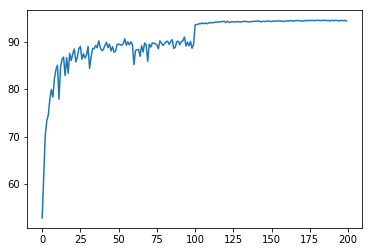

In [21]:
import matplotlib.pyplot as plt
plt.plot(np.arange(acc_erm.shape[0]), acc_erm)
plt.show()

# PreAct ResNet-18 mixup

In [23]:
args = Object()
args.resume = False
args.lr = 0.1
args.alpha = 1.0
classes_num = 10

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


print('==> Building model..')
net = PreActResNet18()

if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for _ in range(2):
        loader_iter = iter(trainloader)
        for inputs1, targets1 in loader_iter:
            if targets1.shape[0] != 128:
                continue
            ##
            inputs2, targets2 = loader_iter.next()
            if targets2.shape[0] != 128:
                continue
            ##

            lam = np.random.beta(args.alpha, args.alpha)
            inputs = (lam*inputs1 + (1. - lam)*inputs2).type(torch.FloatTensor)

            if use_cuda:
                inputs, targets1, targets2 = inputs.cuda(), targets1.cuda(), targets2.cuda()
            optimizer.zero_grad()
            inputs, targets1, targets2 = Variable(inputs), Variable(targets1), Variable(targets2)
            outputs = net(inputs)

            loss1 = criterion(outputs, targets1)
            loss2 = criterion(outputs, targets2)
            loss = (lam*loss1 + (1. - lam)*loss2)

            loss.backward()
            optimizer.step()

            train_loss += loss.data[0]
            _, predicted = torch.max(outputs.data, 1)
            total += targets2.size(0)
            correct += predicted.eq(targets2.data).cpu().sum()
        ##
    ##
    print("Train accuracy: %f" % (100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Test accuracy: %f" % (100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.module if use_cuda else net,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
    return 100.*correct/total

print("==> Done.")

==> Building model..
==> Done.


In [ ]:
acc_mixup = np.zeros(200)

for epoch in range(0, 100):
    train(epoch)
    acc_mixup[epoch] += test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(epoch)
    acc_mixup[epoch] += test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(epoch)
    acc_mixup[epoch] += test(epoch)
##


Epoch: 0
Train accuracy: 24.683494
Test accuracy: 47.410000
Saving..

Epoch: 1
Train accuracy: 35.152244
Test accuracy: 61.690000
Saving..

Epoch: 2
Train accuracy: 34.857772
Test accuracy: 63.190000
Saving..

Epoch: 3
Train accuracy: 41.284054
Test accuracy: 72.270000
Saving..

Epoch: 4
Train accuracy: 43.563702
Test accuracy: 73.890000
Saving..

Epoch: 5
Train accuracy: 42.506010
Test accuracy: 78.940000
Saving..

Epoch: 6
Train accuracy: 42.225561
Test accuracy: 79.220000
Saving..

Epoch: 7
Train accuracy: 45.246394
Test accuracy: 76.920000

Epoch: 8
Train accuracy: 48.161058
Test accuracy: 76.320000

Epoch: 9
Train accuracy: 48.381410
Test accuracy: 83.100000
Saving..

Epoch: 10
Train accuracy: 46.055689
Test accuracy: 81.330000

Epoch: 11
Train accuracy: 45.699119
Test accuracy: 77.270000

Epoch: 12


In [26]:
print("PreAct ResNet-18 mixup error: %f" % (100.0 - best_acc))

PreAct ResNet-18 mixup error: 4.360000


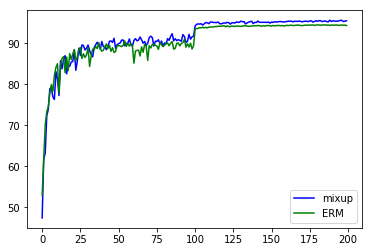

In [34]:
import matplotlib.pyplot as plt
plt.plot(np.arange(acc_mixup.shape[0]), acc_mixup, color='b', label='mixup')
plt.plot(np.arange(acc_erm.shape[0]), acc_erm, color='g', label='ERM')
plt.legend()
plt.show()

# MobileNetV2 ERM

In [35]:
'''MobileNetV2 in PyTorch.

See the paper "Inverted Residuals and Linear Bottlenecks:
Mobile Networks for Classification, Detection and Segmentation" for more details.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [36]:
import numpy as np

args = Object()
args.resume = False
args.lr = 0.1

use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print('==> Building model..')
net = MobileNetV2()

if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        #outputs = outputs.type(torch.LongTensor).cuda()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Train accuracy: %f" % (100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Test accuracy: %f" % (100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.module if use_cuda else net,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
    return 100.*correct/total

print("==> Done.")

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Done.


In [ ]:
acc_mobile_erm = np.zeros(200)

for epoch in range(0, 100):
    train(epoch)
    acc_mobile_erm[epoch] += test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(epoch)
    acc_mobile_erm[epoch] += test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(epoch)
    acc_mobile_erm[epoch] += test(epoch)
##


Epoch: 0
Train accuracy: 38.094000
Test accuracy: 49.940000
Saving..

Epoch: 1


/pio/os/anaconda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type MobileNetV2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/pio/os/anaconda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train accuracy: 58.106000
Test accuracy: 60.590000
Saving..

Epoch: 2
Train accuracy: 67.732000
Test accuracy: 67.440000
Saving..

Epoch: 3
Train accuracy: 73.826000
Test accuracy: 76.010000
Saving..

Epoch: 4
Train accuracy: 76.930000
Test accuracy: 75.770000

Epoch: 5
Train accuracy: 79.130000
Test accuracy: 74.200000

Epoch: 6
Train accuracy: 80.938000
Test accuracy: 81.250000
Saving..

Epoch: 7
Train accuracy: 82.182000
Test accuracy: 79.960000

Epoch: 8
Train accuracy: 83.306000
Test accuracy: 82.380000
Saving..

Epoch: 9
Train accuracy: 84.034000
Test accuracy: 83.770000
Saving..

Epoch: 10
Train accuracy: 84.532000
Test accuracy: 82.110000

Epoch: 11
Train accuracy: 85.330000
Test accuracy: 82.010000

Epoch: 12
Train accuracy: 85.642000
Test accuracy: 84.990000
Saving..

Epoch: 13
Train accuracy: 86.514000
Test accuracy: 84.490000

Epoch: 14
Train accuracy: 86.728000
Test accuracy: 84.630000

Epoch: 15
Train accuracy: 87.204000
Test accuracy: 85.030000
Saving..

Epoch: 16
Train 

In [38]:
print("PreAct MobileNetV2 ERM error: %f" % (100.0 - best_acc))

PreAct MobileNetV2 ERM error: 6.230000


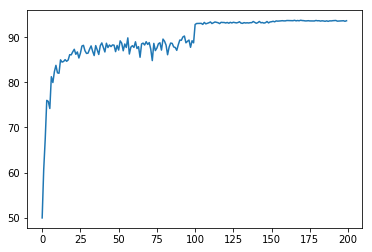

In [39]:
import matplotlib.pyplot as plt
plt.plot(np.arange(acc_mobile_erm.shape[0]), acc_mobile_erm)
plt.show()

# MobileNetV2 mixup

In [41]:
args = Object()
args.resume = False
args.lr = 0.1
args.alpha = 1.0
classes_num = 10

use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


print('==> Building model..')
net = MobileNetV2()

if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for _ in range(2):
        loader_iter = iter(trainloader)
        for inputs1, targets1 in loader_iter:
            if targets1.shape[0] != 128:
                continue
            ##
            inputs2, targets2 = loader_iter.next()
            if targets2.shape[0] != 128:
                continue
            ##

            lam = np.random.beta(args.alpha, args.alpha)
            inputs = (lam*inputs1 + (1. - lam)*inputs2).type(torch.FloatTensor)

            if use_cuda:
                inputs, targets1, targets2 = inputs.cuda(), targets1.cuda(), targets2.cuda()
            optimizer.zero_grad()
            inputs, targets1, targets2 = Variable(inputs), Variable(targets1), Variable(targets2)
            outputs = net(inputs)

            loss1 = criterion(outputs, targets1)
            loss2 = criterion(outputs, targets2)
            loss = (lam*loss1 + (1. - lam)*loss2)

            loss.backward()
            optimizer.step()

            train_loss += loss.data[0]
            _, predicted = torch.max(outputs.data, 1)
            total += targets2.size(0)
            correct += predicted.eq(targets2.data).cpu().sum()
        ##
    ##
    print("Train accuracy: %f" % (100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Test accuracy: %f" % (100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.module if use_cuda else net,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
    return 100.*correct/total

print("==> Done.")

==> Building model..
==> Done.


In [ ]:
acc_mobile_mixup = np.zeros(200)

for epoch in range(0, 100):
    train(epoch)
    acc_mobile_mixup[epoch] += test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(epoch)
    acc_mobile_mixup[epoch] += test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(epoch)
    acc_mobile_mixup[epoch] += test(epoch)
##


Epoch: 0
Train accuracy: 25.210337
Test accuracy: 45.000000
Saving..

Epoch: 1
Train accuracy: 33.597756
Test accuracy: 57.000000
Saving..

Epoch: 2
Train accuracy: 35.941506
Test accuracy: 66.700000
Saving..

Epoch: 3
Train accuracy: 39.569311
Test accuracy: 70.100000
Saving..

Epoch: 4
Train accuracy: 41.458333
Test accuracy: 74.480000
Saving..

Epoch: 5
Train accuracy: 43.383413
Test accuracy: 75.230000
Saving..

Epoch: 6
Train accuracy: 43.595753
Test accuracy: 76.600000
Saving..

Epoch: 7
Train accuracy: 43.511619
Test accuracy: 80.330000
Saving..

Epoch: 8
Train accuracy: 45.506811
Test accuracy: 81.500000
Saving..

Epoch: 9
Train accuracy: 42.940705
Test accuracy: 80.710000

Epoch: 10
Train accuracy: 40.961538
Test accuracy: 82.040000
Saving..

Epoch: 11
Train accuracy: 44.372997
Test accuracy: 81.730000

Epoch: 12
Train accuracy: 45.412660
Test accuracy: 83.050000
Saving..

Epoch: 13
Train accuracy: 45.244391
Test accuracy: 82.860000

Epoch: 14
Train accuracy: 45.098157
Test a

In [45]:
print("PreAct MobileNetV2 mixup error: %f" % (100.0 - best_acc))

PreAct MobileNetV2 mixup error: 5.910000


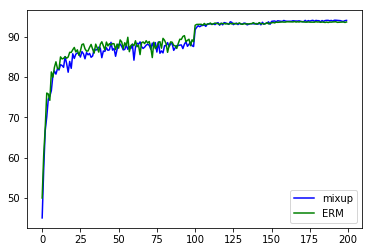

In [46]:
import matplotlib.pyplot as plt
plt.plot(np.arange(acc_mobile_mixup.shape[0]), acc_mobile_mixup, color='b', label='mixup')
plt.plot(np.arange(acc_mobile_erm.shape[0]), acc_mobile_erm, color='g', label='ERM')
plt.legend()
plt.show()

# ShuffleNetG2

In [ ]:
'''ShuffleNet in PyTorch.
See the paper "ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices" for more details.
'''
class ShuffleBlock(nn.Module):
    def __init__(self, groups):
        super(ShuffleBlock, self).__init__()
        self.groups = groups

    def forward(self, x):
        '''Channel shuffle: [N,C,H,W] -> [N,g,C/g,H,W] -> [N,C/g,g,H,w] -> [N,C,H,W]'''
        N,C,H,W = x.size()
        g = self.groups
        return x.view(N,g,C/g,H,W).permute(0,2,1,3,4).contiguous().view(N,C,H,W)


class Bottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, stride, groups):
        super(Bottleneck, self).__init__()
        self.stride = stride

        mid_planes = out_planes/4
        g = 1 if in_planes==24 else groups
        self.conv1 = nn.Conv2d(in_planes, mid_planes, kernel_size=1, groups=g, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_planes)
        self.shuffle1 = ShuffleBlock(groups=g)
        self.conv2 = nn.Conv2d(mid_planes, mid_planes, kernel_size=3, stride=stride, padding=1, groups=mid_planes, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_planes)
        self.conv3 = nn.Conv2d(mid_planes, out_planes, kernel_size=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 2:
            self.shortcut = nn.Sequential(nn.AvgPool2d(3, stride=2, padding=1))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.shuffle1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        res = self.shortcut(x)
        out = F.relu(torch.cat([out,res], 1)) if self.stride==2 else F.relu(out+res)
        return out


class ShuffleNet(nn.Module):
    def __init__(self, cfg):
        super(ShuffleNet, self).__init__()
        out_planes = cfg['out_planes']
        num_blocks = cfg['num_blocks']
        groups = cfg['groups']

        self.conv1 = nn.Conv2d(3, 24, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.in_planes = 24
        self.layer1 = self._make_layer(out_planes[0], num_blocks[0], groups)
        self.layer2 = self._make_layer(out_planes[1], num_blocks[1], groups)
        self.layer3 = self._make_layer(out_planes[2], num_blocks[2], groups)
        self.linear = nn.Linear(out_planes[2], 10)

    def _make_layer(self, out_planes, num_blocks, groups):
        layers = []
        for i in range(num_blocks):
            stride = 2 if i == 0 else 1
            cat_planes = self.in_planes if i == 0 else 0
            layers.append(Bottleneck(self.in_planes, out_planes-cat_planes, stride=stride, groups=groups))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ShuffleNetG2():
    cfg = {
        'out_planes': [200,400,800],
        'num_blocks': [4,8,4],
        'groups': 2
    }
    return ShuffleNet(cfg)

def ShuffleNetG3():
    cfg = {
        'out_planes': [240,480,960],
        'num_blocks': [4,8,4],
        'groups': 3
    }
    return ShuffleNet(cfg)

In [ ]:
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
layers = 100
augment = True
resume = False
alpha = 1.0
best_prec1 = 0
    
# Data loading code
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x/255.0 for x in [63.0, 62.1, 66.7]])
    
if augment:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
        ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        normalize,
        ])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                         transform=transform_train),
    batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transform_test),
    batch_size=batch_size, shuffle=True, **kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create model
model = ShuffleNetG2()
    
# get the number of model parameters
print('Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
    
# for training on multiple GPUs. 
# Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
# model = torch.nn.DataParallel(model).cuda()
model = model.cuda()

# optionally resume from a checkpoint
if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

cudnn.benchmark = True

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum,
                            nesterov=True,
                            weight_decay=weight_decay)

use_cuda = True

def train(trainloader, model, criterion, optimizer, epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
       
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model(inputs)
        #outputs = outputs.type(torch.LongTensor).cuda()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
 
        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Train accuracy: %f" % (100.*correct/total))
    return 100.*correct/total


def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    test_loss = 0
    correct = 0
    total = 0
    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        test_loss += loss.data[0]
        _, predicted = torch.max(output.data, 1)
        total += target_var.size(0)
        correct += predicted.eq(target_var.data).cpu().sum()
    print("Test accuracy: %f" % (100.*correct/total))
    return 100.*correct/total

In [7]:
shuffle_cifar = np.zeros(200)


ttt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(0, 100):
    train(train_loader, model, criterion, optimizer, epoch)
    shuffle_cifar[epoch] = validate(val_loader, model, criterion, epoch)
##

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(train_loader, model, criterion, optimizer, epoch)
    shuffle_cifar[epoch] = validate(val_loader, model, criterion, epoch)
##

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(train_loader, model, criterion, optimizer, epoch)
    shuffle_cifar[epoch] = validate(val_loader, model, criterion, epoch)
#


Epoch: 0
Train accuracy: 33.340000
Test accuracy: 38.880000

Epoch: 1
Train accuracy: 51.742000
Test accuracy: 52.850000

Epoch: 2
Train accuracy: 59.984000
Test accuracy: 62.330000

Epoch: 3
Train accuracy: 64.880000
Test accuracy: 65.950000

Epoch: 4
Train accuracy: 67.892000
Test accuracy: 61.940000

Epoch: 5
Train accuracy: 69.698000
Test accuracy: 68.320000

Epoch: 6
Train accuracy: 71.834000
Test accuracy: 69.940000

Epoch: 7
Train accuracy: 73.466000
Test accuracy: 71.620000

Epoch: 8
Train accuracy: 74.770000
Test accuracy: 62.710000

Epoch: 9
Train accuracy: 76.558000
Test accuracy: 71.230000

Epoch: 10
Train accuracy: 77.940000
Test accuracy: 75.690000

Epoch: 11
Train accuracy: 79.070000
Test accuracy: 73.440000

Epoch: 12
Train accuracy: 80.258000
Test accuracy: 75.580000

Epoch: 13
Train accuracy: 81.178000
Test accuracy: 78.490000

Epoch: 14
Train accuracy: 81.980000
Test accuracy: 75.400000

Epoch: 15
Train accuracy: 82.864000
Test accuracy: 77.830000

Epoch: 16
Train a

Train accuracy: 99.256000
Test accuracy: 90.850000

Epoch: 133
Train accuracy: 99.238000
Test accuracy: 90.960000

Epoch: 134
Train accuracy: 99.326000
Test accuracy: 90.720000

Epoch: 135
Train accuracy: 99.410000
Test accuracy: 90.740000

Epoch: 136
Train accuracy: 99.330000
Test accuracy: 90.840000

Epoch: 137
Train accuracy: 99.374000
Test accuracy: 90.920000

Epoch: 138
Train accuracy: 99.370000
Test accuracy: 91.020000

Epoch: 139
Train accuracy: 99.328000
Test accuracy: 91.010000

Epoch: 140
Train accuracy: 99.378000
Test accuracy: 90.700000

Epoch: 141
Train accuracy: 99.456000
Test accuracy: 90.920000

Epoch: 142
Train accuracy: 99.470000
Test accuracy: 90.870000

Epoch: 143
Train accuracy: 99.460000
Test accuracy: 90.820000

Epoch: 144
Train accuracy: 99.398000
Test accuracy: 91.010000

Epoch: 145
Train accuracy: 99.342000
Test accuracy: 90.520000

Epoch: 146
Train accuracy: 99.472000
Test accuracy: 90.870000

Epoch: 147
Train accuracy: 99.484000
Test accuracy: 90.920000

Epo

# ShuffleNetG2 mixup

In [ ]:
### MIXUP ###
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
augment = True
resume = False
alpha = 1.0
best_prec1 = 0

    
# Data loading code
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x/255.0 for x in [63.0, 62.1, 66.7]])
    
if augment:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
        ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        normalize,
        ])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])

kwargs = {'num_workers': 1, 'pin_memory': True}
trainloader_cifar = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                         transform=transform_train),
    batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transform_test),
    batch_size=batch_size, shuffle=True, **kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create model
model = ShuffleNetG2()
    
# get the number of model parameters
print('Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
    
# for training on multiple GPUs. 
# Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
# model = torch.nn.DataParallel(model).cuda()
model = model.cuda()

# optionally resume from a checkpoint
if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

cudnn.benchmark = True

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum,
                            nesterov=True,
                            weight_decay=weight_decay)

use_cuda = True

def train(model, criterion, optimizer, epoch):
    global trainloader_cifar
    """Train for one epoch on the training set"""

    # switch to train mode
    model.train()
    test_loss = 0
    correct = 0
    total = 0

    print('\nEpoch: %d' % epoch)
    for iteration in range(0,2):
        trainloader_enumerate = enumerate(trainloader_cifar)

        for batch_idx, (inputs1, targets1) in trainloader_enumerate:
            try:
                _, (inputs2, targets2) = trainloader_enumerate.next()
            except StopIteration:
                trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
                if iteration == 1:
                    print("Train accuracy: %f" % (100.*correct/total))
                    return
                else:
                    break
            lam = np.random.beta(alpha, alpha)
            input = (lam*inputs1 + (1. - lam)*inputs2).type(torch.FloatTensor)

            targets1 = targets1.type(torch.LongTensor)
            targets2 = targets2.type(torch.LongTensor)

            input, targets1, targets2 = torch.autograd.Variable(input), torch.autograd.Variable(targets1), torch.autograd.Variable(targets2)
            if use_cuda:
                input, targets1, targets2 = input.cuda(), targets1.cuda(), targets2.cuda()
            # compute output
            outputs = model(input)
            loss1 = criterion(outputs, targets1)
            loss2 = criterion(outputs, targets2)
            loss = (lam*loss1 + (1. - lam)*loss2)

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            _, predicted = torch.max(outputs.data, 1)
            total += targets1.size(0)
            correct += predicted.eq(targets1.data).cpu().sum()


def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    test_loss = 0
    correct = 0
    total = 0
    # switch to evaluate mode
    model.eval()

    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        test_loss += loss.data[0]
        _, predicted = torch.max(output.data, 1)
        total += target_var.size(0)
        correct += predicted.eq(target_var.data).cpu().sum()
    print("Test accuracy: %f" % (100.*correct/total))
    return 100.*correct/total

In [15]:
shuffle_cifar_mixup = np.zeros(200)

ttt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(0, 100):
    train(model, criterion, optimizer, epoch)
    shuffle_cifar_mixup[epoch] = validate(val_loader, model, criterion, epoch)
##

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(model, criterion, optimizer, epoch)
    shuffle_cifar_mixup[epoch] = validate(val_loader, model, criterion, epoch)
##

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(model, criterion, optimizer, epoch)
    shuffle_cifar_mixup[epoch] = validate(val_loader, model, criterion, epoch)
#


Epoch: 0
Train accuracy: 19.765625
Test accuracy: 43.800000

Epoch: 1
Train accuracy: 28.369391
Test accuracy: 49.750000

Epoch: 2
Train accuracy: 29.885817
Test accuracy: 55.890000

Epoch: 3
Train accuracy: 34.320913
Test accuracy: 58.350000

Epoch: 4
Train accuracy: 34.559295
Test accuracy: 58.430000

Epoch: 5
Train accuracy: 34.435096
Test accuracy: 63.430000

Epoch: 6
Train accuracy: 36.502404
Test accuracy: 64.800000

Epoch: 7
Train accuracy: 35.432692
Test accuracy: 66.730000

Epoch: 8
Train accuracy: 39.296875
Test accuracy: 64.820000

Epoch: 9
Train accuracy: 39.721554
Test accuracy: 66.030000

Epoch: 10
Train accuracy: 38.129006
Test accuracy: 68.450000

Epoch: 11
Train accuracy: 39.941907
Test accuracy: 70.360000

Epoch: 12
Train accuracy: 41.332131
Test accuracy: 67.330000

Epoch: 13
Train accuracy: 44.102564
Test accuracy: 73.970000

Epoch: 14
Train accuracy: 42.063301
Test accuracy: 76.170000

Epoch: 15
Train accuracy: 42.277644
Test accuracy: 71.390000

Epoch: 16
Train a

Train accuracy: 50.194311
Test accuracy: 91.230000

Epoch: 133
Train accuracy: 49.589343
Test accuracy: 91.090000

Epoch: 134
Train accuracy: 51.137821
Test accuracy: 91.420000

Epoch: 135
Train accuracy: 52.315705
Test accuracy: 91.210000

Epoch: 136
Train accuracy: 49.871795
Test accuracy: 91.490000

Epoch: 137
Train accuracy: 51.913061
Test accuracy: 91.570000

Epoch: 138
Train accuracy: 52.085337
Test accuracy: 91.640000

Epoch: 139
Train accuracy: 52.267628
Test accuracy: 91.490000

Epoch: 140
Train accuracy: 52.894631
Test accuracy: 91.320000

Epoch: 141
Train accuracy: 54.034455
Test accuracy: 91.640000

Epoch: 142
Train accuracy: 52.105369
Test accuracy: 91.310000

Epoch: 143
Train accuracy: 49.128606
Test accuracy: 91.350000

Epoch: 144
Train accuracy: 49.234776
Test accuracy: 90.650000

Epoch: 145
Train accuracy: 53.199119
Test accuracy: 91.280000

Epoch: 146
Train accuracy: 52.638221
Test accuracy: 90.910000

Epoch: 147
Train accuracy: 51.730769
Test accuracy: 91.550000

Epo

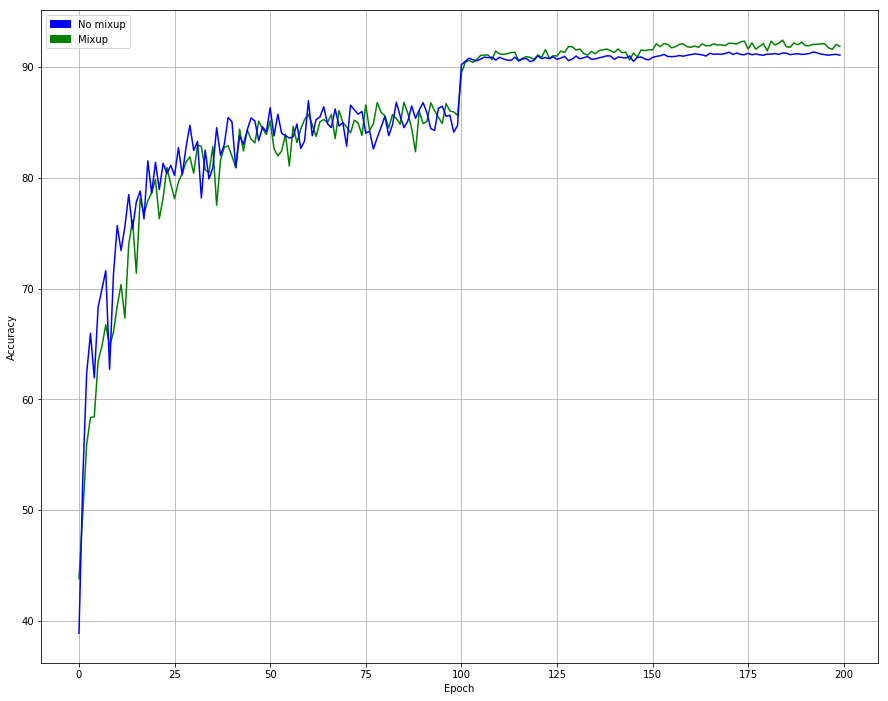

Best ShuffleNet mixup accuracy was 92.440000% in epoch 184
Best ShuffleNet accuracy without mixup was 91.370000% in epoch 192


In [16]:
plt.figure(figsize=(15,12))

plt.plot(np.arange(shuffle_cifar_mixup.shape[0]), shuffle_cifar_mixup, color='g')
plt.plot(np.arange(shuffle_cifar.shape[0]), shuffle_cifar, color='b')

blue_patch = mpatches.Patch(color='b', label='No mixup')
green_patch = mpatches.Patch(color='g', label='Mixup')
plt.legend(handles=[blue_patch,green_patch])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print ('Best ShuffleNet mixup accuracy was %f%% in epoch %d' %(shuffle_cifar_mixup.max(), np.argsort(shuffle_cifar_mixup)[-1:]))
print ('Best ShuffleNet accuracy without mixup was %f%% in epoch %d' %(shuffle_cifar.max(), np.argsort(shuffle_cifar)[-1:]))

# ResNet50

In [22]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [50]:
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
augment = True
resume = False
alpha = 1.0
best_prec1 = 0

#global args, best_prec1
#args = parser.parse_args()
#if args.tensorboard: configure("runs/%s"%(args.name))
    
# Data loading code
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x/255.0 for x in [63.0, 62.1, 66.7]])
    
if augment:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
        ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        normalize,
        ])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader_resnet50 = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                         transform=transform_train),
    batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transform_test),
    batch_size=batch_size, shuffle=True, **kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create model
model = ResNet50()
    
# get the number of model parameters
print('Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
    
# for training on multiple GPUs. 
# Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
# model = torch.nn.DataParallel(model).cuda()
model = model.cuda()

# optionally resume from a checkpoint
if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

cudnn.benchmark = True

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum,
                            nesterov=True,
                            weight_decay=weight_decay)

use_cuda = True

def train(model, criterion, optimizer, epoch):
    global train_loader_resnet50
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader_resnet50):
       
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
 
        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Train accuracy: %f" % (100.*correct/total))
    return 100.*correct/total


def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    test_loss = 0
    correct = 0
    total = 0
    # switch to evaluate mode
    model.eval()

    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        test_loss += loss.data[0]
        _, predicted = torch.max(output.data, 1)
        total += target_var.size(0)
        correct += predicted.eq(target_var.data).cpu().sum()
    print("Test accuracy: %f" % (100.*correct/total))
    return 100.*correct/total

Files already downloaded and verified
Number of model parameters: 23520842


In [ ]:
resnet50 = np.zeros(200)

for epoch in range(0, 100):
    train( model, criterion, optimizer, epoch)
    resnet50[epoch] = validate(val_loader, model, criterion, epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(model, criterion, optimizer, epoch)
    resnet50[epoch] = validate(val_loader, model, criterion, epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(model, criterion, optimizer, epoch)
    resnet50[epoch] = validate(val_loader, model, criterion, epoch)
##


Epoch: 0
Train accuracy: 21.634000
Test accuracy: 32.750000

Epoch: 1


# ResNet50 mixup

In [ ]:
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
augment = True
resume = False
alpha = 1.0
best_prec1 = 0
    
# Data loading code
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x/255.0 for x in [63.0, 62.1, 66.7]])
    
if augment:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
        ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        normalize,
        ])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader_cifar_res = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                         transform=transform_train),
    batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transform_test),
    batch_size=batch_size, shuffle=True, **kwargs)

# create model
model = ResNet50()
    
# get the number of model parameters
print('Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
    
# for training on multiple GPUs. 
# Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
# model = torch.nn.DataParallel(model).cuda()
model = model.cuda()

# optionally resume from a checkpoint
if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

cudnn.benchmark = True

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum,
                            nesterov=True,
                            weight_decay=weight_decay)

use_cuda = True

def train(model, criterion, optimizer, epoch):
    global train_loader_cifar_res
    """Train for one epoch on the training set"""
    test_loss = 0
    correct = 0
    total = 0
    # switch to train mode
    model.train()
    print('\nEpoch: %d' % epoch)
    for iteration in range(0,2):
        trainloader_enumerate = enumerate(train_loader_cifar_res)

        for batch_idx, (inputs1, targets1) in trainloader_enumerate:
            try:
                _, (inputs2, targets2) = trainloader_enumerate.next()
            except StopIteration:
                trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
                if iteration == 1:
                    print("Train accuracy: %f" % (100.*correct/total))
                    return
                else:
                    break
            lam = np.random.beta(alpha, alpha)
            input = (lam*inputs1 + (1. - lam)*inputs2).type(torch.FloatTensor)

            targets1 = targets1.type(torch.LongTensor)
            targets2 = targets2.type(torch.LongTensor)

            input, targets1, targets2 = torch.autograd.Variable(input), torch.autograd.Variable(targets1), torch.autograd.Variable(targets2)
            if use_cuda:
                input, targets1, targets2 = input.cuda(), targets1.cuda(), targets2.cuda()
            # compute output
            output = model(input)
            loss1 = criterion(output, targets1)
            loss2 = criterion(output, targets2)
            loss = (lam*loss1 + (1. - lam)*loss2)


            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(output.data, 1)
            total += targets1.size(0)
            correct += predicted.eq(targets1.data).cpu().sum()



def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    test_loss = 0
    correct = 0
    total = 0
    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)
        
        _, predicted = torch.max(output.data, 1)
        total += target_var.size(0)
        correct += predicted.eq(target_var.data).cpu().sum()

    print("Test accuracy: %f" % (100.*correct/total))
    return 100.*correct/total

In [ ]:
resnet_mixup = np.zeros(200)

for epoch in range(0, 100):
    train( model, criterion, optimizer, epoch)
    resnet_mixup[epoch] = validate(val_loader, model, criterion, epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(model, criterion, optimizer, epoch)
    resnet_mixup[epoch] = validate(val_loader, model, criterion, epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(model, criterion, optimizer, epoch)
    resnet_mixup[epoch] = validate(val_loader, model, criterion, epoch)
##


Epoch: 0
Train accuracy: 15.178285
Test accuracy: 29.780000

Epoch: 1
Train accuracy: 22.658253
Test accuracy: 38.580000

Epoch: 2
Train accuracy: 26.181891
Test accuracy: 41.220000

Epoch: 3
Train accuracy: 27.205529
Test accuracy: 47.220000

Epoch: 4
Train accuracy: 30.544872
Test accuracy: 50.130000

Epoch: 5
Train accuracy: 31.400240
Test accuracy: 56.060000

Epoch: 6
Train accuracy: 33.697917
Test accuracy: 57.630000

Epoch: 7
Train accuracy: 35.324519
Test accuracy: 61.380000

Epoch: 8
Train accuracy: 34.813702
Test accuracy: 61.140000

Epoch: 9
Train accuracy: 35.184295
Test accuracy: 64.820000

Epoch: 10
Train accuracy: 39.913862
Test accuracy: 67.770000

Epoch: 11
Train accuracy: 40.044071
Test accuracy: 70.920000

Epoch: 12
Train accuracy: 42.560096
Test accuracy: 71.770000

Epoch: 13
Train accuracy: 40.200321
Test accuracy: 74.110000

Epoch: 14
Train accuracy: 44.879808
Test accuracy: 75.410000

Epoch: 15
Train accuracy: 43.173077
Test accuracy: 76.570000

Epoch: 16
Train a

Train accuracy: 51.053686
Test accuracy: 89.930000

Epoch: 133
Train accuracy: 49.927885
Test accuracy: 89.970000

Epoch: 134
Train accuracy: 50.731170
Test accuracy: 90.140000

Epoch: 135
Train accuracy: 51.378205
Test accuracy: 90.240000

Epoch: 136
Train accuracy: 49.332933
Test accuracy: 90.380000

Epoch: 137
Train accuracy: 50.663061
Test accuracy: 90.260000

Epoch: 138
Train accuracy: 50.280449
Test accuracy: 90.040000

Epoch: 139
Train accuracy: 54.250801
Test accuracy: 90.160000

Epoch: 140
Train accuracy: 51.023638
Test accuracy: 90.110000

Epoch: 141
Train accuracy: 51.750801
Test accuracy: 90.320000

Epoch: 142
Train accuracy: 49.537260
Test accuracy: 89.320000

Epoch: 143
Train accuracy: 50.612981
Test accuracy: 89.960000

Epoch: 144
Train accuracy: 48.417468
Test accuracy: 90.080000

Epoch: 145
Train accuracy: 52.319712
Test accuracy: 90.020000

Epoch: 146
Train accuracy: 50.074119
Test accuracy: 90.470000

Epoch: 147
Train accuracy: 51.951122


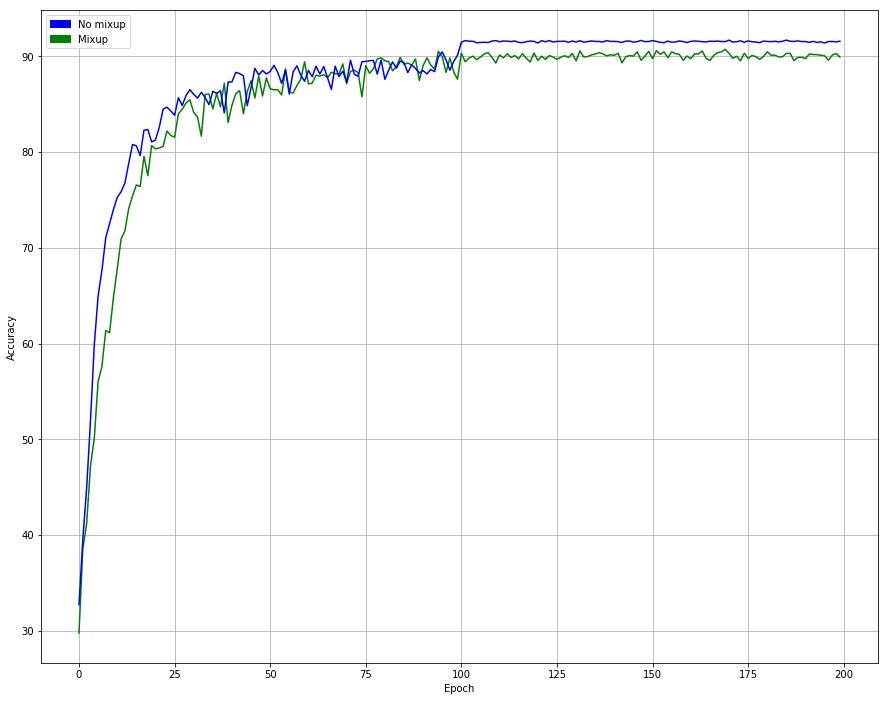

Best ResNet50 mixup accuracy was 90.730000% in epoch 169
Best ResNet50 accuracy without mixup was 91.690000% in epoch 170


In [60]:
plt.figure(figsize=(15,12))

plt.plot(np.arange(resnet_mixup.shape[0]), resnet_mixup, color='g')
plt.plot(np.arange(resnet50.shape[0]), resnet50, color='b')

blue_patch = mpatches.Patch(color='b', label='No mixup')
green_patch = mpatches.Patch(color='g', label='Mixup')
plt.legend(handles=[blue_patch,green_patch])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print ('Best ResNet50 mixup accuracy was %f%% in epoch %d' %(resnet_mixup.max(), np.argsort(resnet_mixup)[-1:]))
print ('Best ResNet50 accuracy without mixup was %f%% in epoch %d' %(resnet50.max(), np.argsort(resnet50)[-1:]))

# PreAct ResNet-18 MNIST

In [ ]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])

In [25]:
'''Train CIFAR10 with PyTorch.'''

class Object():
    pass
args = Object()
args.resume = False
args.lr = 0.1
args.alpha = 1.0

use_cuda = True#torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0')

# Model
if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7')
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
else:
    print('==> Building model..')
    net = PreActResNet18()

if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)

a = iter(trainloader)
train_data, train_labels = a.next()
train_data, train_labels = train_data.clone(), train_labels.clone()
for d, l in a:
    train_data = torch.cat((train_data, d.clone()))
    train_labels = torch.cat((train_labels, l.clone()))

BATCH_SIZE = 128

#training_error = np.zeros((200*469))
#test_accuracy = np.zeros((200))

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
       
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        #outputs = outputs.type(torch.LongTensor).cuda()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
 
        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Train accuracy: %f" % (100.*correct/total))
    #return 100.*correct/total
    
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
       
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
 
        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print("Test accuracy: %f" % (100.*correct/total))
 
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.module if use_cuda else net,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
    return 100.*correct/total

print("==> Done")

==> Preparing data..
Processing...
Done!
==> Building model..
==> Done


In [26]:
preactresnet_mnist = np.zeros(200)

for epoch in range(0, 100):
    train(epoch)
    preactresnet_mnist[epoch] = test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(epoch)
    preactresnet_mnist[epoch] = test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(epoch)
    preactresnet_mnist[epoch] = test(epoch)
#




Epoch: 0
Train accuracy: 83.861667
Test accuracy: 93.860000
Saving..

Epoch: 1


/pio/os/anaconda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PreActResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/pio/os/anaconda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PreActBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train accuracy: 96.253333
Test accuracy: 95.850000
Saving..

Epoch: 2
Train accuracy: 97.275000
Test accuracy: 97.510000
Saving..

Epoch: 3
Train accuracy: 97.901667
Test accuracy: 98.030000
Saving..

Epoch: 4
Train accuracy: 98.113333
Test accuracy: 98.110000
Saving..

Epoch: 5
Train accuracy: 98.323333
Test accuracy: 98.620000
Saving..

Epoch: 6
Train accuracy: 98.386667
Test accuracy: 98.390000

Epoch: 7
Train accuracy: 98.443333
Test accuracy: 98.540000

Epoch: 8
Train accuracy: 98.555000
Test accuracy: 98.180000

Epoch: 9
Train accuracy: 98.575000
Test accuracy: 98.360000

Epoch: 10
Train accuracy: 98.606667
Test accuracy: 97.710000

Epoch: 11
Train accuracy: 98.681667
Test accuracy: 98.300000

Epoch: 12
Train accuracy: 98.666667
Test accuracy: 98.210000

Epoch: 13
Train accuracy: 98.768333
Test accuracy: 98.020000

Epoch: 14
Train accuracy: 98.711667
Test accuracy: 98.740000
Saving..

Epoch: 15
Train accuracy: 98.760000
Test accuracy: 98.640000

Epoch: 16
Train accuracy: 98.84166

Train accuracy: 99.870000
Test accuracy: 99.220000

Epoch: 132
Train accuracy: 99.893333
Test accuracy: 99.260000

Epoch: 133
Train accuracy: 99.893333
Test accuracy: 99.180000

Epoch: 134
Train accuracy: 99.913333
Test accuracy: 99.140000

Epoch: 135
Train accuracy: 99.906667
Test accuracy: 99.100000

Epoch: 136
Train accuracy: 99.898333
Test accuracy: 99.160000

Epoch: 137
Train accuracy: 99.906667
Test accuracy: 99.300000

Epoch: 138
Train accuracy: 99.911667
Test accuracy: 99.260000

Epoch: 139
Train accuracy: 99.908333
Test accuracy: 99.170000

Epoch: 140
Train accuracy: 99.916667
Test accuracy: 99.170000

Epoch: 141
Train accuracy: 99.915000
Test accuracy: 99.160000

Epoch: 142
Train accuracy: 99.920000
Test accuracy: 99.090000

Epoch: 143
Train accuracy: 99.910000
Test accuracy: 99.170000

Epoch: 144
Train accuracy: 99.910000
Test accuracy: 99.140000

Epoch: 145
Train accuracy: 99.910000
Test accuracy: 99.150000

Epoch: 146
Train accuracy: 99.911667
Test accuracy: 99.220000

Epo

# PreAct ResNet-18 MNIST mixup

In [3]:
'''Train CIFAR10 with PyTorch.'''
class Object():
    pass
args = Object()
args.resume = False
args.lr = 0.1
args.alpha = 1.0

use_cuda = True#torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader_mnist = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0')

# Model
if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7')
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
else:
    print('==> Building model..')
    net = PreActResNet18()

if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)

MIXUP = True
MIXUP_RATE = 1.0
BATCH_SIZE = 128
# Training
def train(epoch):
    global trainloader_mnist
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for iteration in range(0,2):
        trainloader_enumerate = enumerate(trainloader_mnist)

        for batch_idx, (inputs1, targets1) in trainloader_enumerate:

            try:
                _, (inputs2, targets2) = trainloader_enumerate.next()
            except StopIteration:
                trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
                if iteration == 1:
                    print("Train accuracy: %f" % (100.*correct/total))
                    return
                else:
                    break

            lam = np.random.beta(args.alpha, args.alpha)
            inputs = (lam*inputs1 + (1. - lam)*inputs2).type(torch.FloatTensor)
            targets1 = targets1.type(torch.LongTensor)
            targets2 = targets2.type(torch.LongTensor)

            if use_cuda:
                inputs, targets1, targets2 = inputs.cuda(), targets1.cuda(), targets2.cuda()
            optimizer.zero_grad()
            inputs, targets1, targets2 = Variable(inputs), Variable(targets1), Variable(targets2)
            outputs = net(inputs)

            loss1 = criterion(outputs, targets1)
            loss2 = criterion(outputs, targets2)
            loss = (lam*loss1 + (1. - lam)*loss2)

            loss.backward()
            optimizer.step()

            train_loss += loss.data[0]
            _, predicted = torch.max(outputs.data, 1)
            total += targets1.size(0)
            correct += predicted.eq(targets1.data).cpu().sum()
    #return 100.*correct/total
    
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        

    # Save checkpoint.
    acc = 100.*correct/total
    print("Test accuracy: %f" % acc)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.module if use_cuda else net,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
    return acc

print("==> Done")

==> Preparing data..
==> Building model..
==> Done


In [ ]:
preactresnet_mnist_mixup = np.zeros(200)

for epoch in range(0, 100):
    train(epoch)
    preactresnet_mnist_mixup[epoch] = test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(100, 150):
    train(epoch)
    preactresnet_mnist_mixup[epoch] = test(epoch)
##

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
for epoch in range(150, 200):
    train(epoch)
    preactresnet_mnist_mixup[epoch] = test(epoch)
#


Epoch: 0
Train accuracy: 44.491186
Test accuracy: 93.930000
Saving..

Epoch: 1


/pio/os/anaconda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PreActResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/pio/os/anaconda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PreActBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


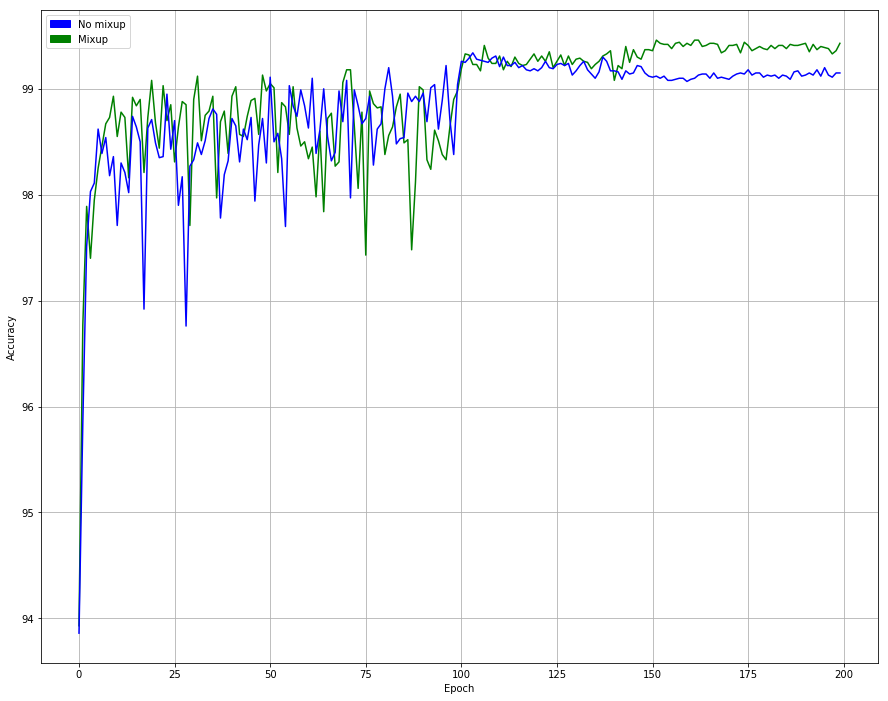

Best mixup accuracy was 99.460000% in epoch 151
Best accuracy without mixup was 99.340000% in epoch 103


In [12]:
plt.figure(figsize=(15,12))
plt.plot(np.arange(preactresnet_mnist_mixup.shape[0]), preactresnet_mnist_mixup, color='g')
plt.plot(np.arange(preactresnet_mnist.shape[0]), preactresnet_mnist, color='b')

blue_patch = mpatches.Patch(color='b', label='No mixup')
green_patch = mpatches.Patch(color='g', label='Mixup')
plt.legend(handles=[blue_patch,green_patch])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print ('Best mixup accuracy was %f%% in epoch %d' %(preactresnet_mnist_mixup.max(), np.argsort(preactresnet_mnist_mixup)[-1:]))
print ('Best accuracy without mixup was %f%% in epoch %d' %(preactresnet_mnist.max(), np.argsort(preactresnet_mnist)[-1:]))